# Download Midi Data

In [13]:
import os
import mido
import string
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
cwd = os.getcwd()+'/'

In [2]:
midi_data_dir = cwd+'midi_data/'

if not os.path.exists(midi_data_dir):
    os.makedirs(midi_data_dir)

In [3]:
from midi_utils import play_midi

# download music if it hasn't already been downloaded
if len(os.listdir(midi_data_dir)) == 0:
    from midi_utils import download_midis
    download_midis(midi_data_dir)

# Play Midis

In [4]:
ex_midi_file = midi_data_dir+'EspanjaPrelude.mid'

play_midi(ex_midi_file)

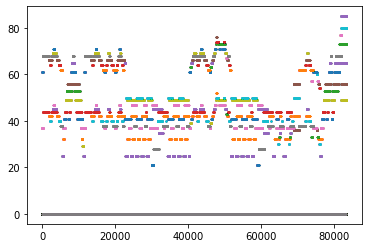

In [5]:
from midi_ndarrays import *
import mido
midi_tracks = mido.MidiFile(ex_midi_file, clip=True)
result_array = mid2array(midi_tracks)
plt.show(visualize_midi_array(result_array))

In [11]:
result_array.shape

(83279, 88)

# The Model

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        
        self.dropout   = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn       = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_p)
        
    def forward(self, x):
        embedding = self.dropout(self.embedding(x))
        outputs, (h, c) = self.rnn(embedding)
        return h, c

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, 
                num_layers, dropout_p):
    
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers  = numm_layers

        self.dropout   = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_p)
        
        # output 88 size
        self.fc = nn.Linerar(hidden_size, output_size)
        
    def forward(self, x, hidden, cell):
        x = x.unsqueeze(0)
        
        embedding = self.dropout(self.embedding(x))
        
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        
        predictions = self.fc(outputs)
         
        predictions = predictions.squeeze(0)
        
        return predictions, hidden, cell

In [80]:
def train(num_epochs=20,
          learning_rate=0.001,
          batch_size=64,
          input_size=88,
          hidden_size=1024,
          num_layers=2,
          dropout_p=0.5,
          data_dir="midi_data"):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_files = len(os.listdir(data_dir))
    
    # TODO construct encoder and decoder
    for epoch in range(num_epochs):
        
        batch_idx = 0
        
        for batch in range(batch_size):
            if batch_idx == num_files-1:
                break
                
            midi_file = data_dir+'/'+os.listdir(data_dir)[batch_idx]
            
            # load one data point
            midi_track = mido.MidiFile(midi_file, clip=True)
            midi_array = mid2array(midi_track).astype('float64')
          
            # make each entry between 0 and 1 (velocity is between 0 and 127)
            midi_array /= 127
            
            # padding for start and end tokens (instead of 88rows for each of the 88 notes,
            # we now have 90 rows, the first for the start token, and the last for the end token)
            midi_array = np.pad(midi_array, 1)
            
            # encode start and end tokens
            midi_array[0, 0] = 1
            midi_array[-1, -1] = 1)

(124319, 88)
